# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


# DataCamp Certification - Data Scientist - Recipe Site Traffic - Written Report

## Project Description
As a Data Scientist at Tasty Bytes, I have been task with helping the product team increase traffic to our website using an analytical approach.

### Business goals
The business goal of the project is clear:
- help the product team increase traffic of our whole website
    - Why: higher traffic means more suscriptions and thus more revenue for the company
    - How: showing popular recipes on the recipe site can lead to higher traffic (up to 40% higher) for the rest of the website

This project's goal aligned with the business goal is thus to try to **predict** recipes that will lead to high traffic (popular) and also predict recipes that might lead to low traffic (unpopular). This way, the product recipe team can show more of the former and less of the latter.

### Technical approach
To help achieve this goal, we will follow an analytical approach, based on the data the product team has provided:
1. Validate and if necessary clean the data
2. Exploratory Data Analysis
3. Selection and training of predictive model
4. Evaluation of predictive model
5. Connect model performance to the business goal/metric
6. Results and recommendations

A note about the problem type: since we are trying to predict if a given recipe leads to high-traffic **based on past success** this is a so-called supervised problem.

## 0. Preparation

For better readability, we import and provide an overview of imported modules in one place:

In [32]:
# Basic modules
import pandas as pd
import numpy as np

# Data prep related
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_color_codes(palette='pastel')

# Model training
from sklearn.preprocessing import LabelEncoder

## 1. Data Validation
We will take an overview of the data and each variable, so as to determine if the data needs to be cleaned and prepared to be suitable for our analysis further on.

In [33]:
# Import the data and visualize it
df = pd.read_csv('recipe_site_traffic_2212.csv')

print(f"The raw data has {df.shape[0]} rows and {df.shape[1]} columns")

df.head()

The raw data has 947 rows and 8 columns


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


From looking at a couple of rows we already gain two valuable ingisghts:
1. The variable we are trying to predict *high_traffic* appears to be a categorical value, not a numeric one. That means that our supervised learning problem is more specifically a categorization one (as opposed to f.e. numeric regression).
2. There are some data points that contain no data *null*, which we'll take a look at now: 

In [34]:
print('How many duplicates are there in the table?')
print(df.duplicated().sum())
print('--------------')
print('Check for data type and null-entries:')
df.info()

How many duplicates are there in the table?
0
--------------
Check for data type and null-entries:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


### Let's start with the non-numeric variables

In [35]:
print(df['servings'].value_counts())
print(df['category'].value_counts())
print(df['high_traffic'].value_counts())

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64
High    574
Name: high_traffic, dtype: int64


**Validation non-numeric columns**:
- *servings*: from the data description, this data should be numeric but it contains three entries with text on it. **(Cleaning task 1)**
- *category*: We learn here, that the data contains one food category (*Chicken Breast*) that is not in the data description from the product team. **(Cleaning task 2)**
- *high_traffic*: looks like it has many *null* entries. From the description of the product management team, we know that this columns is used to mark the recipes that showed high-traffic of the website, or otherwise no entry. So there is no need to remove these rows, since they also contain information, i.e. these recipes did not show high traffic **(Cleaning task 3)**.

**Cleaning Task 1 - servings column**
The text in the three data entries points to the fact that the servings are 'snacks' and thus not full servings. Since the column contains valuable numeric information, it would not be ideal to leave it as a character type.

> Asumption - please check: So for these three data points, we will remove the text and divide the number by two, so as to take into account that the servings are smaller.
> - `4 as a snack` becomes `2`
> - `6 as a snack` becomes `3`

Finally, we will convert the column to numeric for the models to make more precise predicitons.

In [36]:
df.loc[df['servings'] == '4 as a snack', 'servings'] = 2
df.loc[df['servings'] == '6 as a snack', 'servings'] = 3
df["servings"] = pd.to_numeric(df["servings"])

**Cleaning Task 2 - category**
> Assumption - please check: the product manager/team only wants to include the categories given by them, so we will change the entries *Chicken Breast* to *Chicken*

In [37]:
df.loc[df['category'] == 'Chicken Breast', 'category'] = 'Chicken'

**Cleaning Task 3 - high_traffic**
> Assumption - please check: we assume that the recipes with a *null* entry in the *high_traffic* column showed 'Low' traffic.

Since *null* entries are harder to work with, we will replace them with 'Low' for the *high_traffic* variable.

In [38]:
df["high_traffic"] =  df["high_traffic"].fillna('Low')

In [39]:
# Check results
print(df[["servings", "category", "high_traffic"]].info())
print(df['servings'].value_counts())
print(df['category'].value_counts())
print(df['high_traffic'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   servings      947 non-null    int64 
 1   category      947 non-null    object
 2   high_traffic  947 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.3+ KB
None
4    389
6    197
2    185
1    175
3      1
Name: servings, dtype: int64
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64
High    574
Low     373
Name: high_traffic, dtype: int64


**Validation numeric columns**:

In [40]:
print(f"Number of unique values in 'recipe' column: {df['recipe'].unique().shape[0]}")

Number of unique values in 'recipe' column: 947


In [41]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,947.000000,895.000000,895.000000,895.000000,895.000000,947.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296,3.469905
std,273.519652,453.020997,43.949032,14.679176,36.369739,1.732018
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,710.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


- *recipe*: contains indeed 947 unique numeric IDs, so nothing to change here.
- The rest of the columns are similar in the sense that:
    - they are all continuous and judging from their descriptive statistics, they all look like relative plausible values. It does seem, however that some recipes have almost no *calories*, let's look into that:

In [42]:
df.loc[df["calories"] < 10,]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
20,21,9.26,17.44,8.16,10.81,Potato,6,High
58,59,6.23,56.43,5.60,2.12,Lunch/Snacks,6,High
140,141,4.22,3.46,10.93,0.74,Beverages,6,Low
167,168,4.41,239.06,19.54,3.76,Dessert,1,High
228,229,0.14,18.12,11.15,87.34,Lunch/Snacks,2,High
276,277,0.76,1.90,3.76,0.05,Vegetable,2,High
387,388,2.14,20.11,0.16,1.42,Beverages,4,Low
486,487,7.55,54.19,0.91,14.18,Lunch/Snacks,1,High
500,501,0.30,5.19,0.96,1.51,Beverages,4,Low
512,513,7.39,4.47,11.62,10.75,Vegetable,4,High


Indeed, there seem to be recipes, e.g. recipe id 588 with only 1.56 calories, even tough it contains almost 60 grams of carbs, ~6 grams of sugar and 35 grams of protein, is pork based and serves four dishes. This seems extremly unlikely. However, since we do not have a direct contact with the product manager or recipe team to check or recalculate the calories, we will continue with the data as is and make the recommendation to validate this point and if needed, to improve on the data with the product team and retrain the models.

> Assumption - please check: some recipes (e.g. 588) contain unlikely low amount of calories for the amount of carbs, sugar and protein. At this point, with no further information, we will continue with the values as they were given to us.

That leaves the null-entries for the numeric cols:

In [43]:
df.loc[df["protein"].isnull(),]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,Low
48,49,NaN,NaN,NaN,NaN,Chicken,4,Low
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


> Assumption - please check: It looks like the numeric variables (ignoring *recipe*) are all *null* at the same level. Using the mean to fill 52 rows (out of 947), would regress each column too much to their mean. So since, 895 columns are enough to train our models, we will leave out the null-rows.

In [44]:
df = df.dropna()
df.shape[0]

895

In [45]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        895 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      895 non-null    object 
 6   servings      895 non-null    int64  
 7   high_traffic  895 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 62.9+ KB
None


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High


## 2. Exploratory Data Analysis

### Train, Test Samples
As is best practice in machine learning projects, we will split our cleaned and validated data in into a train and test samples so as to not bias our data analysis work. We will use the conventional function `train_test_split()`, with a test size of 30%.

In [46]:
# Split independent variables (X) and dependent variable (y, here high_traffic)
y = df["high_traffic"]
X = df.drop(columns=["high_traffic"])

# Split data into test and train samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Validate split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(626, 7) (626,) (269, 7) (269,)


### Numerical variables

Above, we discussed the isse of the *calories* column having very low numbers on some rows, let's explore its distribution:

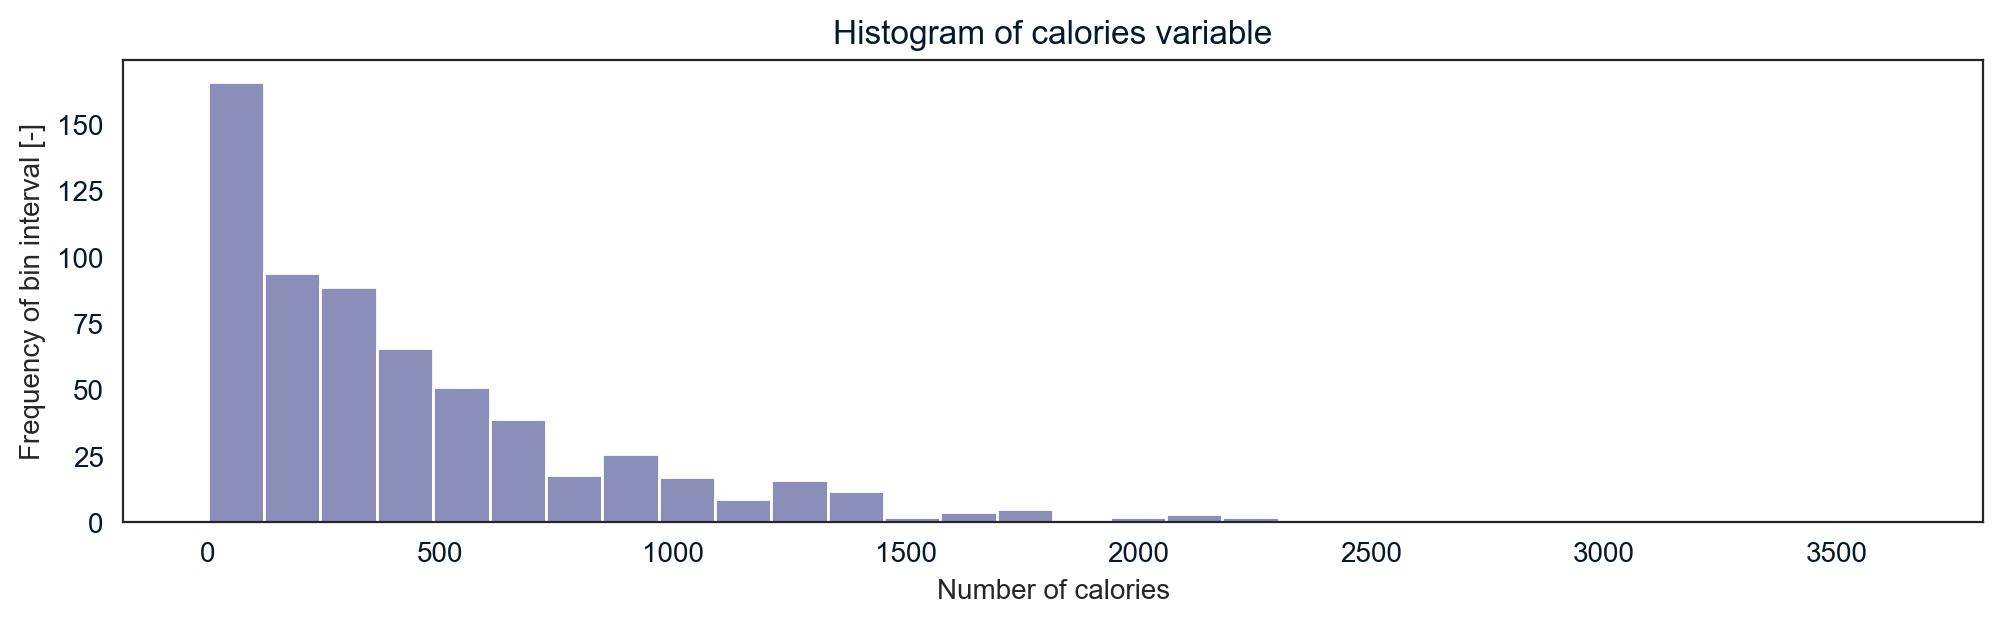

In [47]:
f, ax = plt.subplots(figsize=(12, 3))
sns.histplot(data=X_train["calories"], bins=30)
ax.set(title='Histogram of calories variable', xlabel='Number of calories', ylabel='Frequency of bin interval [-]')
plt.show()

As suspected above, there is a suspicious large amount of data points where the total number of calories are between 0 and 125 grams. Let's see how the other numerical variables are distributed and how they relate to the calories variable (except for *recipe* since its only an id):

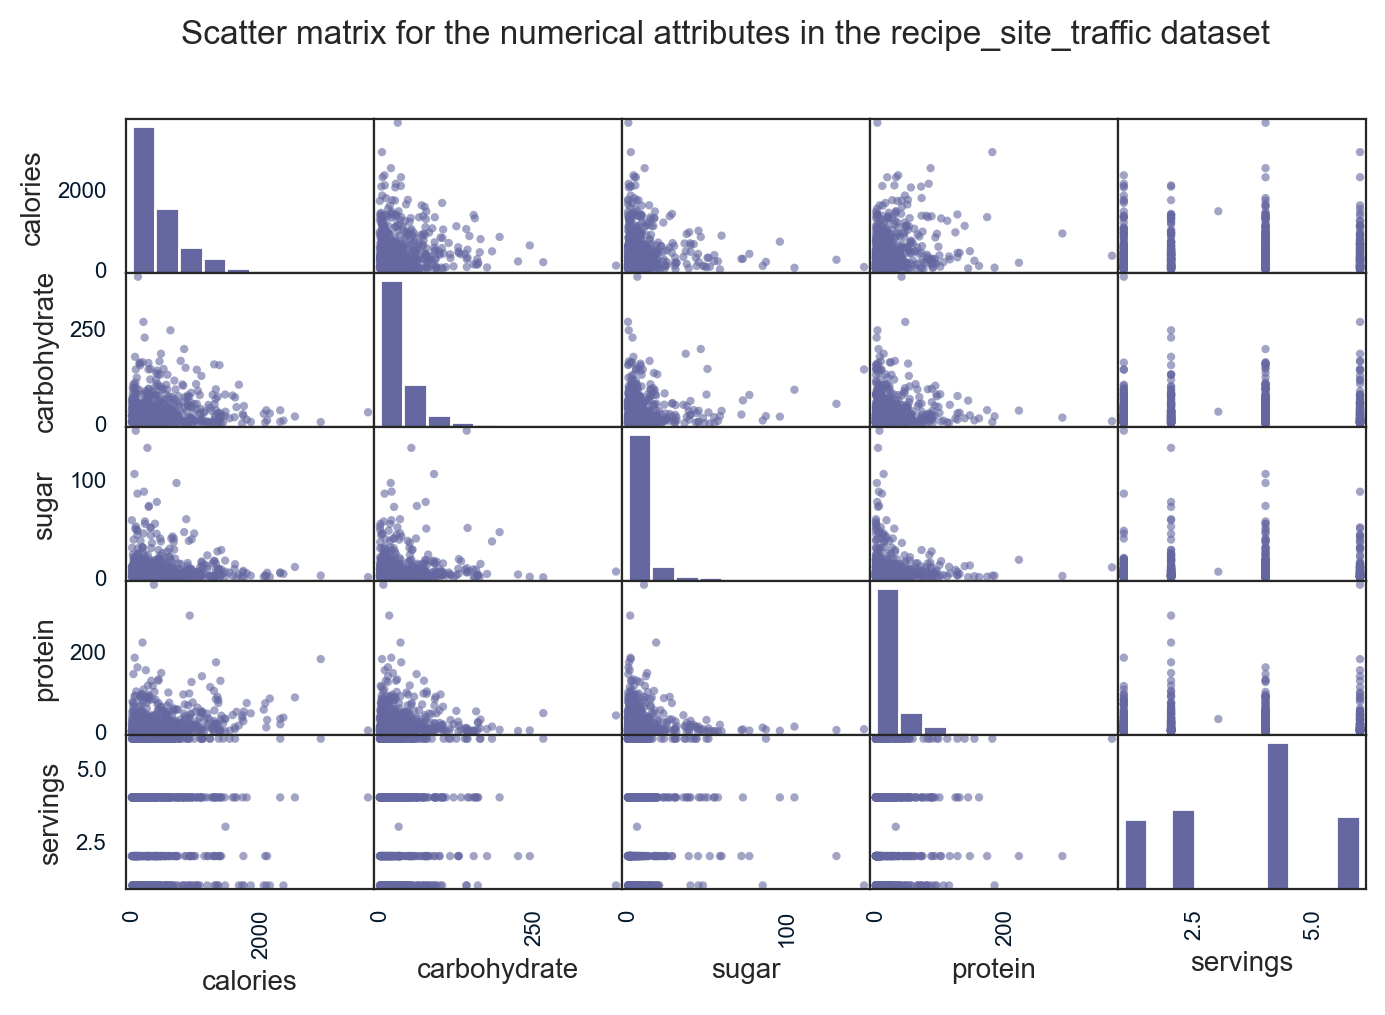

In [48]:
num_attr = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
pd.plotting.scatter_matrix(X_train[num_attr], figsize=(8, 5), alpha=0.6, diagonal='hist')
plt.suptitle('Scatter matrix for the numerical attributes in the recipe_site_traffic dataset')
plt.show()

This chart supports our suspicion that there is something wrong with the calories variable data. From the first row / top chart, you can see that *protein*, *sugar* and *carbohydrate* have a negative correlation. But we know that the larger their amount, the larger the amount of calories should be. Furthermore, the amount of calories can be directly approximated with the amount of carbs, proteins and fat, so in accordance with keeping only independent variables and the low quality of the *calories* we will drop the column entirely.

> Assumption - please check: The value of calories for some recipes do not seem plausible. Before risking biasing the predicitive model with false data, we will drop the *calories* column. This is in line with methods such as PCA (principal component analysis), to focus on the variables that most explain the predictive variable. Since carbs, sugar and protein are indicative of calories, a large part of that information is already contained in the former.

In [49]:
# Delete 'calories' from both train and test datasets
X_train = X_train.drop("calories", axis=1)
X_test = X_test.drop("calories", axis=1)

Now let's take a look at how the numerical variables relate to our dependent variable *high_traffic*:

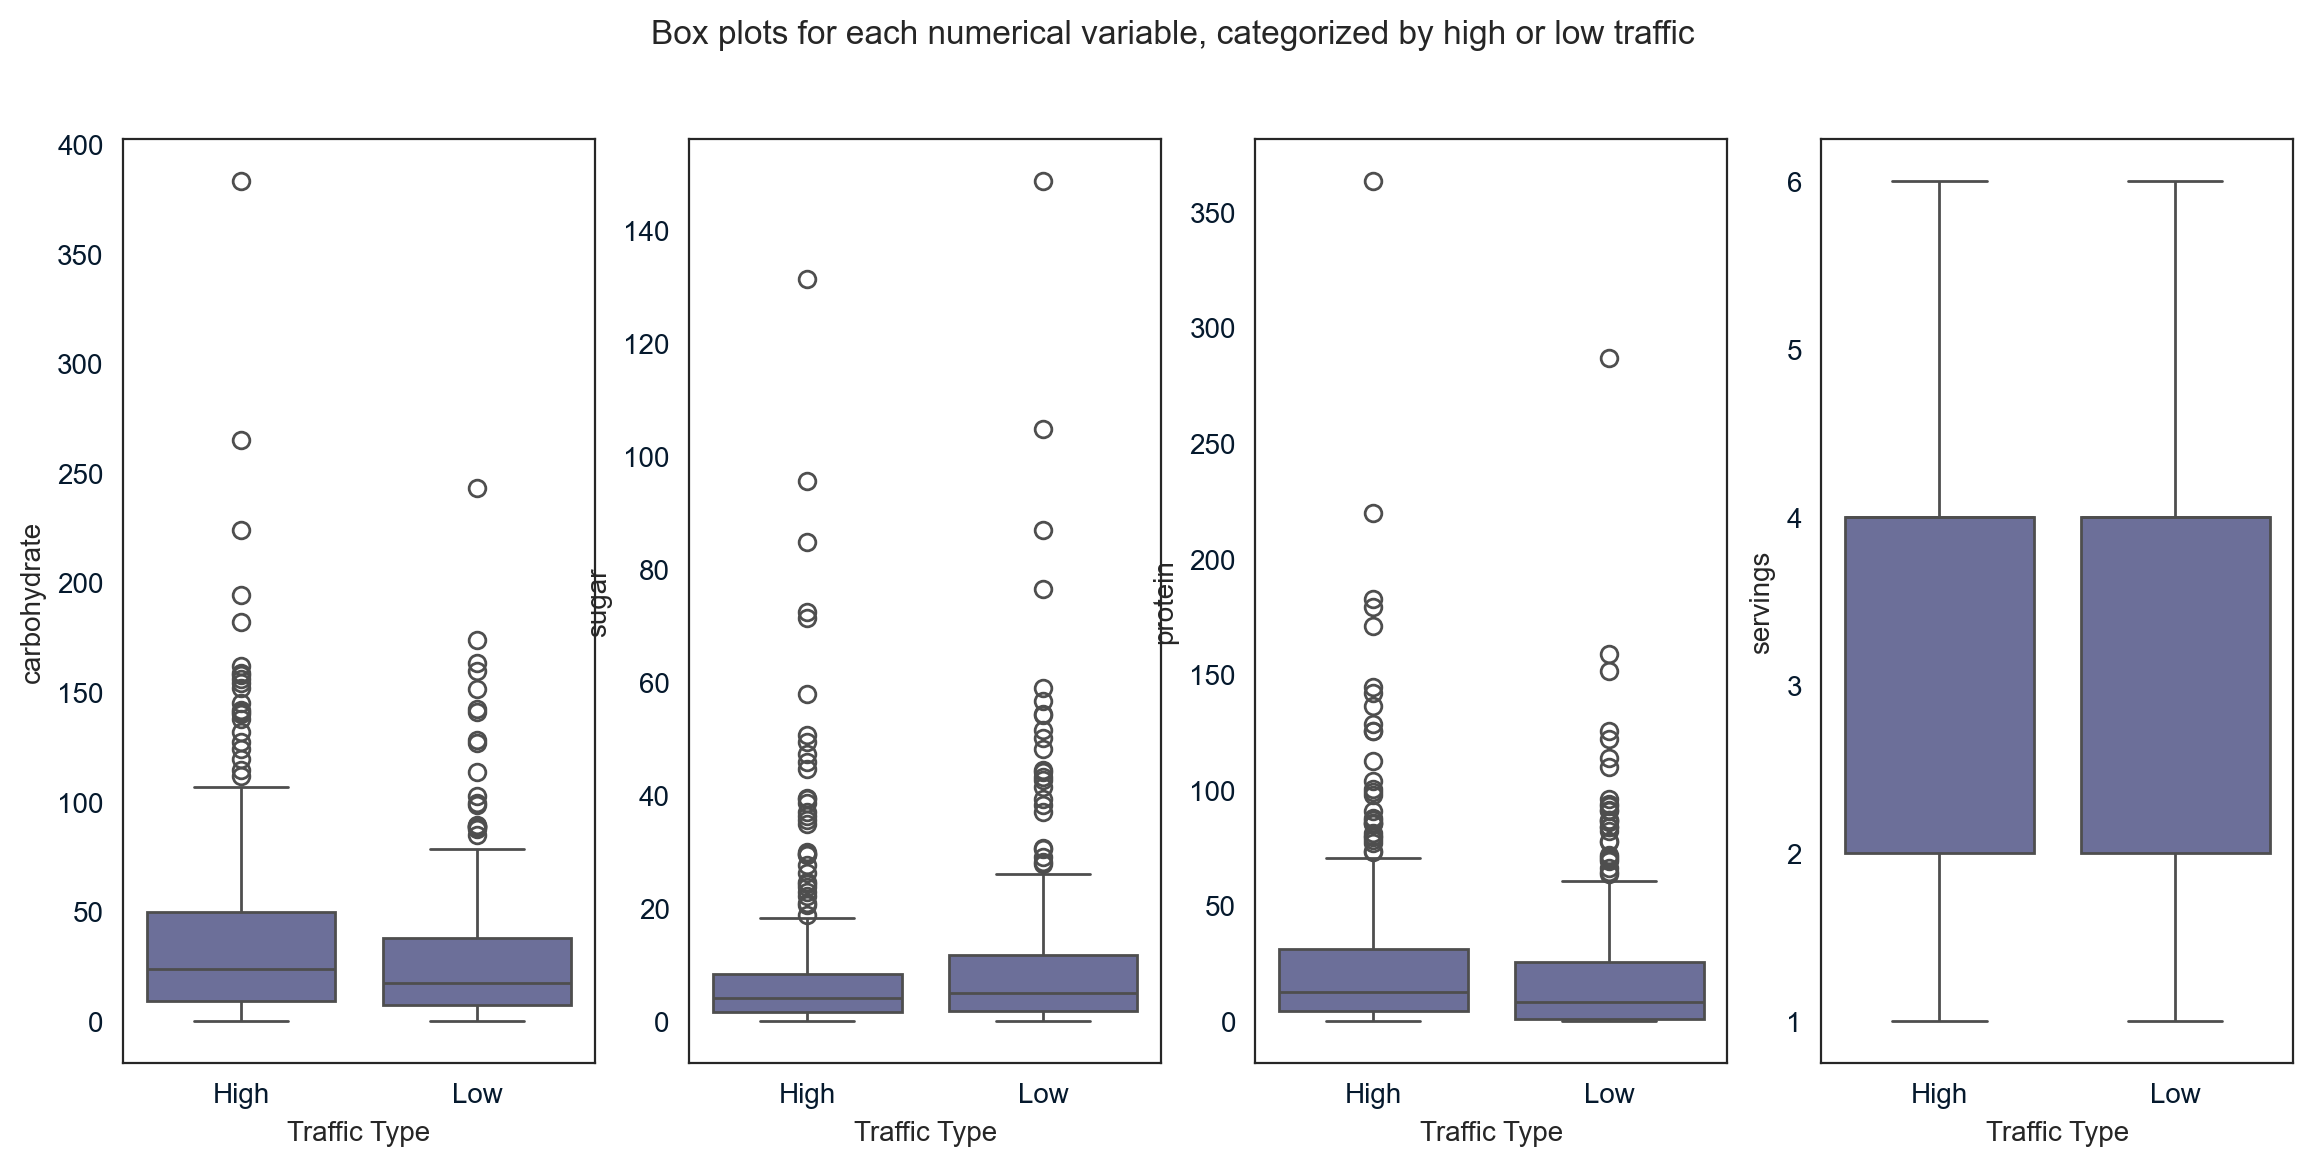

In [50]:
df_train = pd.concat([y_train, X_train], axis=1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(14,6), nrows=1, ncols=4, sharey=False)

sns.boxplot(x='high_traffic', ax=ax1, y='carbohydrate', data=df_train)
ax1.set(xlabel='Traffic Type')

sns.boxplot(x='high_traffic', ax=ax2, y='sugar', data=df_train)
ax2.set(xlabel='Traffic Type')

sns.boxplot(x='high_traffic', ax=ax3, y='protein', data=df_train)
ax3.set(xlabel='Traffic Type')

sns.boxplot(x='high_traffic', ax=ax4, y='servings', data=df_train)
ax4.set(xlabel='Traffic Type')

plt.suptitle('Box plots for each numerical variable, categorized by high or low traffic')

# Display the plot
plt.show()

There do not appear to be any obvious patterns that might make a clear correlation between the variables and lower or higher traffic. Howevever, it is interesting that for *carbohydrate* and *protein* the popular recipes appear to have a higher amount of each (average), whereas for *sugar* it appears to be slightly the other way around.

### Categorical variables
Now let's explore our only dependent categorical value *category*:

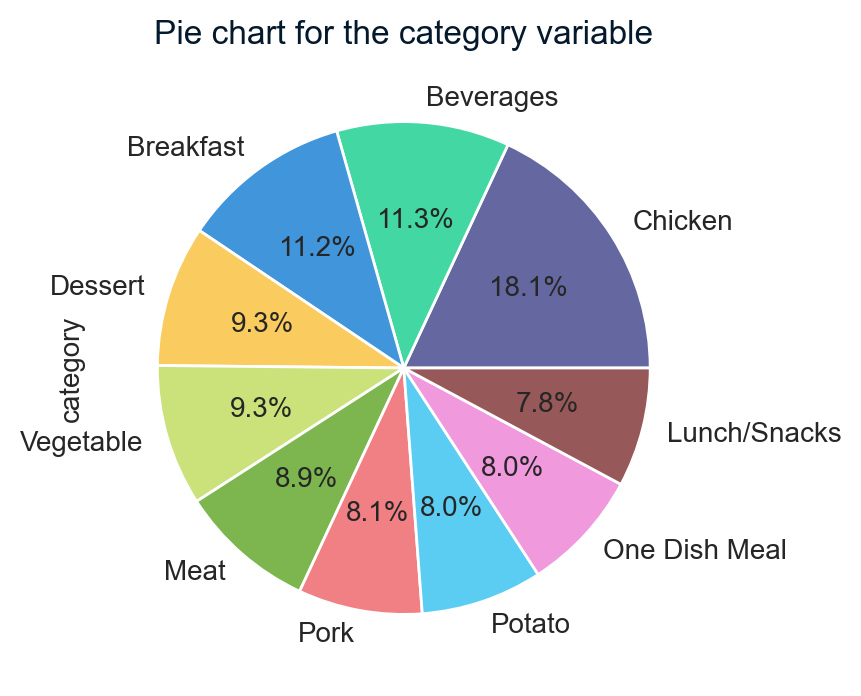

In [51]:
fig, ax = plt.subplots(figsize=(10, 4))
X_train['category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart for the category variable')
plt.show()

From the pie chart we do not gain much insight, other than the food categories are near evenly distributed. Let's explore how the ratio of high or low traffic is for each category:

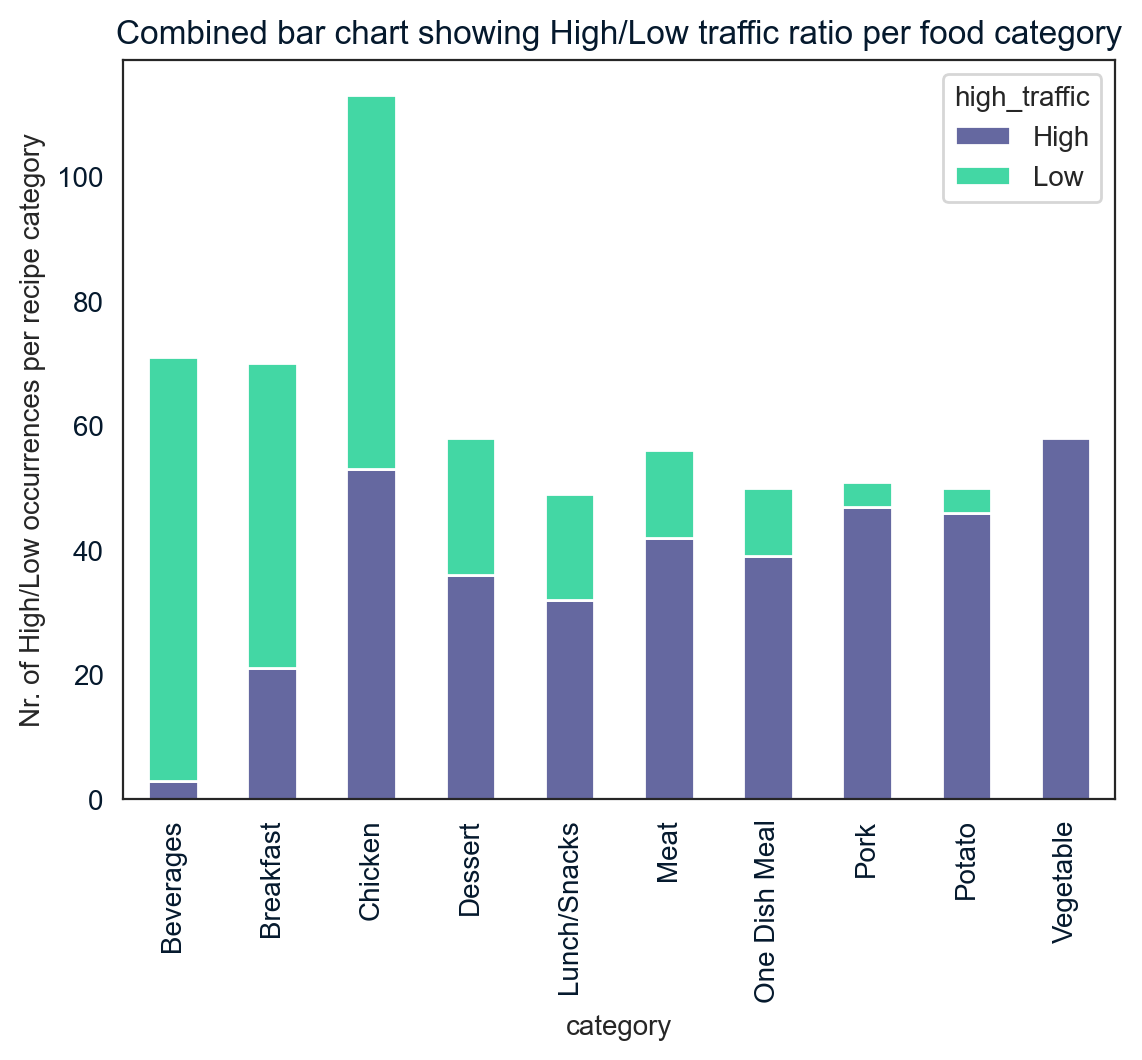

In [52]:
pd.crosstab(df_train['category'], df_train['high_traffic']).plot(kind='bar', stacked=True)
plt.ylabel("Nr. of High/Low occurrences per recipe category")
plt.title("Combined bar chart showing High/Low traffic ratio per food category")
plt.show()

This chart is quite revealing. We learn that depending on the category, there is a very different ocurrence of high or low traffic. At first look, it appears as if all *vegetable* recipes get high traffic. The positive high/low ratio remains true for the majority of categories, until *Chicken*, where it appers to be level. On the other hand for most *beverages* recipes, there appears to be a low traffic.

## 3. Selection and training of predictive model
As mentioned before, since our variable to be predicted *high_traffic* is categorical (*High* or *Low*), this is a **classification** problem. The predictive model we are going to train, shall, for each new recipe data it gets predict if the recipe is likely to have a ***High*** or ***Low*** 'class'.

### Model selection
We will chose a baseline model and a so-called productive model. Both will be trained on the same data and will try to predict the same variable. The baseline model will be used as a comparison for our productive model, to measure its performance. If the predictive model proves to be better, than we might use it in a productive setting with the product team.

- Baseline model: **Decision Tree classifier**. Decision Trees models are simple to use, to understand and to explain. They are not great at general tasks, but this is a specific task and they are well-suited for classification. The scikit-learn implementation cannot handle categorical variables, which is why we will do some label encoding over the *category* and *high_traffic* variables [2].
- Productive model: **Random Forest Classifier**. We chose this as our predictive model, since it also well-suited for a classification problem. It has the advantage, that it tends to be more accurate but less interpretable than a Decision Tree. However, aligned with our business need, interpretability is not as important as getting accurate predictions. Moreover, we saw in the box-plot data from the numeric variable, that there are quite some outliers data points, which Random Forest tend to be more robust on than Decision Trees. Last but not least, Decision Trees are both easier to train and deliver a quicker prediction, but with the amount of data we are using, this should not be a relevant factor. For these reasons we chose Random Forest Classifier.

At this point it is important to mention, that we will drop the variable 'recipe' whic was just an identifier for each recipe and does not have any relation at all with the amount of traffic each recipe has.

In [53]:
# Encoding categorical variables
df_v2 = df.drop(columns=["calories", "recipe"])

le = LabelEncoder()
df_v2['category_enc'] = le.fit_transform(df['category'])
df_v2['high_traffic_enc'] = le.fit_transform(df['high_traffic'])
df_v2.head()

,carbohydrate,sugar,protein,category,servings,high_traffic,category_enc,high_traffic_enc
1,38.56,0.66,0.92,Potato,4,High,8,0
2,42.68,3.09,2.88,Breakfast,1,Low,1,1
3,30.56,38.63,0.02,Beverages,4,High,0,0
4,1.85,0.80,0.53,Beverages,4,Low,0,1
5,3.46,1.65,53.93,One Dish Meal,2,High,6,0


It is important to note that the "High" has been encoded to 0 and "Low" to 1 for the dependent variable *high_traffic*

In [54]:
df_v2 = df_v2.drop(columns=["category", "high_traffic"])
df_v2.head()

,carbohydrate,sugar,protein,servings,category_enc,high_traffic_enc
1,38.56,0.66,0.92,4,8,0
2,42.68,3.09,2.88,1,1,1
3,30.56,38.63,0.02,4,0,0
4,1.85,0.80,0.53,4,0,1
5,3.46,1.65,53.93,2,6,0


In [55]:
# Redo the train, test split with same parameter and random_state as before
y = df_v2["high_traffic_enc"]
X = df_v2.drop(columns=["high_traffic_enc"])

# Split data into test and train samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.head(3))
y_train.head(3)

     carbohydrate  sugar  protein  servings  category_enc
689         60.94   1.05     4.45         4             8
181         23.16  20.99     5.63         6             3
478         26.13   3.17    19.42         6             2


689    0
181    0
478    0
Name: high_traffic_enc, dtype: int64

Now let's import and train our baseline model: Decision Tree classifier. For training we are going to use or training data and after we get the model, we are going to predict on our test data.

In [56]:
from sklearn.tree import DecisionTreeClassifier
clf_base = DecisionTreeClassifier()

# Train the model using the training sets
clf_base.fit(X_train, y_train)

# Predict the response for test dataset
y_predic_base = clf_base.predict(X_test)

# Predict on the train dataset for testing
y_train_pred_base = clf_base.predict(X_train)

Now we repeat the same train and predict process for our Random Forest model. The Random Forest Classifier has a parameter *n_estimators* we can tune, however for the time we have, we will chose *80* to keep it simple and quick.

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf_prod = RandomForestClassifier(n_estimators=80)

# Train the model using the training sets
clf_prod.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_prod = clf_prod.predict(X_test)

# Predict on the train dataset for testing
y_train_pred_prod = clf_prod.predict(X_train)

Now, that we have trained both models and made predictions on our test dataset. We will compare them, starting with an accuracy score, which tells us: what percentage of the predictions did we get right? (i.e. the higher, the better)

In [58]:
# Print the accuracy score for baseline model
print("Accuracy for baseline model (DT):", accuracy_score(y_test, y_predic_base))
# Print the accuracy score for predictive model
print("Accuracy for predictive model (RT)", accuracy_score(y_test, y_pred_prod))

Accuracy for baseline model (DT): 0.6319702602230484
Accuracy for predictive model (RT) 0.7100371747211895


Since, every time you run the models and the accuracy score, you might get slightly different numbers, we put the output we got here, which should not change the major point we are making:

Accuracy for baseline model (DT): 0.6468401486988847
Accuracy for predictive model (RT) 0.7211895910780669

The predictive model was about 8 pct points higher than the baseline model, that is a ~12% better accuracy at predicting high-traffic recipes, which is what we are interested in. This acccuracy comparison is in line with our expectations about the selected approaches for the baseline (Decision Tree) and the predictive model (Random Forest):
- Random Forest tends to show a higher accuracy in its prediction, than the simpler Decision Tree model
- The training and predicting time, although theoretically higher for Random Forest, was insignificant with the amount of data we have
- As mentioned, RF are less interpretable and more complex than Decision Tree. Interpretability is not as relevant to this business problem and with that 'complexity' of Random Forest comes more robustness towards outliers and overfitting. 

We will test overfitting, by comparing the y-values of the train data with the predicted values of both models based on the train data, which we have already calculated above:

In [59]:
print("Accuracy baseline model on train data (DT):", accuracy_score(y_train, y_train_pred_base))
print("Accuracy for predictive model on train data (RT)", accuracy_score(y_train, y_train_pred_prod))

Accuracy baseline model on train data (DT): 1.0
Accuracy for predictive model on train data (RT) 1.0


Both models have a 100% accuracy on the train data. Since the perform perfetly as compared to the test data, this is a clear sign of overfitting, which is surely to be an issue for new recipe data in the future. However, for the time we have, we will continue with these models and talk about recommendations and possible improvements steps later.

### Business Metrics

As stated at the beginnig of the project, the business goal is to increase traffic. These can be done by either showing more popular recipes but also avoid showing unpopular recipes, as well. We define two KPIs aligned to these two business goals:
1. True Positives (TP): how many of all the high-traffic recipes, were correctly predicted as such
2. False Positives (FP): how many of the low-traffic recipes, were predicted falsely as "high-traffic"

> Note: The higher the TP, the more confident the team can be that a "high-traffic" predicted recipe is indeed one and a lower FP, gives more confidence that the team will not show a "high-traffic" predicted recipe, that will actually lead to low-traffic.

To calculate this we use the confusion matrix. Note, since the "High" value we are interested in for traffic is encoded as "0", the value in the confusion matrix at position (0,0) is actually called True Negative in a binary classification, but for business-oriented work, we will use the terms above, indicating a correctly predicted "High" traffic for a "True Positive" [3].

In [60]:
from sklearn.metrics import confusion_matrix

cm_base = confusion_matrix(y_test, y_predic_base)
cm_pred = confusion_matrix(y_test, y_pred_prod)

print("Base Model:")
print(f"TP-base: {cm_base[0,0]}, FP-base: {cm_base[1,0]}")
print("Predictive Model:")
print(f"TP-base: {cm_pred[0,0]}, FP-base: {cm_pred[1,0]}")

Base Model:
TP-base: 104, FP-base: 45
Predictive Model:
TP-base: 126, FP-base: 46


Here we can see how both models perform in relation to our defined business KPIs. Our predictive model (Random Forest) appear to have more True Positives (128 > 111) than our based model. This means, that our predictive model is more helpful to select high-traffic recipes that are likely to lead to high-traffic. However, both models appear to have a similar number of False Positives, which means there is a significant amount (almost half as much as the TP) of recipes labeled as "High" that might not lead to high-traffic.

## 6. Results and recommendations
### Busines focus
The goal of this project was to use recipe data and their respective historical "high" trafficto create an analytical model that can predict if a future recipe data is likely to lead to "high" traffic or not. One of the stated goals was to predict 80% of the time if any given recipe is going to be popular. To approach this we first validated and cleaned the data and did some exploratory data analysis. Later, we chose a comparison model for baseline classification-predictions based on Decision Tree and a predictive/productive model based on Random Forest. We trained them, and tested them accordingly.

As suggested by our Head of Data Science, in the given timeframe we were not able to achieve this. Our best, predictive model, based on Random Forest Classifier had an accuracy of ~72%, which does not directly show the probability that any given recipe will 80% of the be popoular (i.e. have "high" traffic) but it is a good place to start. Specially, compared to the baseline model with an accuracy of ~ 61%.

Our other stated goals, was to get predictions from the model to try to increase the chance of showing popular recipes. This we measured with the "True Positive" metric, where again our predictive model surpassed the baseline model. For the KPI of minimizing showing of unpopular recipes ("Low" traffic), the models performed similarly.

In view of our above-stated business goals, we can state, that the predictive model shows a higher accuracy and higher True Positive-hits than our based model, and thus should be the one to use for now, for our predictions.

### Recommendation for future action
We recommend to start using the productive/predictive model in a test environment, that is maybe doing A/B testing on the website. A subset of users (group A) could be shown the human-curated recipes and a different website users can be shown the recipes that the model predicts to lead to "high" traffic. Additionally, within group B, we can gather more data, to check the TP and FP values for the model. In this way we can learn if 1. the model is as-is better than the human selected recipes in leading to higher traffic and 2. use the learning data to refit the model and improve it over time.

In this way the model can be used to start making a direct impact, predict the "High" or "Low" class of a given new recipe and assist the product team in their decision.

### Recommendations for improvement and critical analysis:
- Check assumptions as denoted throughout the document: we made several decisions on the way that might need a deep-dive between the Data Sciente team and the product team to test their validity and if necessary make changes.
- Check specially the data for recipes where the amount of calories is low, e.g. less than 10 but the sum of carbohydrates, sugar and protein is way larger than 10 (e.g. recipe 588). Enforce appropiate methods to calculate the proper amount of calories for each recipe. If necessary, compare how models with/without calories column compare to each other.
- We recognized that overfitting of the predictive models is an issue, that should be adressed in the future.

- Another idea to **improve our business goals**, is to focus on the *category* of the shown recipes. We saw that the majority of recipes in the categories of 'Beverages' and 'Breakfast' lead to low traffic. The frequency of both categories was higher than some better performing ones. This might be necessary do to an unknown business need. If it is not, we recommend the product team to try reducing the share of 'Beverages' and 'Breakfast' recipes shown on the website. If this is not possible, than it might be a good idea to try to better understand, within each category (e.g. 'Beverages'), which drinks lead to "Low" and which to "High" traffic.
    - If there is more data to be have, one could even try to create a model based only on 'Beverages' and more data, to keep showing beverages, but try to increase the "High" traffic ones.

## References
- [1] https://www.livestrong.com/article/81042-calculate-percentage-calories-fat-carbohydrate/
- [2] https://scikit-learn.org/stable/modules/tree.html
- [3] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation